<a href="https://colab.research.google.com/github/UmangGada/My-Projects/blob/main/project_fire_final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Uncertainty in Boston Daily Fire Incident Rates
## Authors: Adam Batten, Umang Gada, Matt Trupiano

# Introduction

In this project we look to model the behavior of the daily count of fire incidents in the city of Boston in a given month. The data was obtained from the fire incident data sets found on Boston's open data portal: https://data.boston.gov/dataset/fire-incident-reporting. We pulled all the monthly data for the years of 2018-2020, and all the monthly released data for 2021 as well (through March). The code for this pull and data formatting can be found in the ETL/EDA section.

The framing for this project is in the context of building a relatively simple forecasting model for the distribution of the daily count of incidents in a given month of the year. Which could be a component of a problem in city planning/budgeting. For example, "what will firefighter headcount need to be throughout the year in order to be prepared for the vast majority of daily incident volumes"? As such we fit the model on training set consisting of data prior to the most recent 12 months, setting aside that last year of data to be used in testing model forecast performance on new months. 

In addition to the tests on future data we plot and provide estimates of quantiles for all the marginal posteriors, and provide diagnostics on the MCMC fit. 


## Environment

In [ ]:
#Mount the google drive 
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
#Stan install 
# command line install of V8 package to avoid rstan issues
system('sudo apt-get install -y libv8-dev')
Sys.setenv(MAKEFLAGS= paste0("-j",parallel::detectCores()))
install.packages("rstan", dependencies = T, repos = "https://cloud.r-project.org")
install.packages("bayesplot")


In [ ]:
%%R
library(rstan)
#Load Data Manipulation Packages
library('dplyr')
library('lubridate')
library(bayesplot)

## ETL/EDA

Here we import the data needed from Boston's open data portal, and summarize the results to the daily level. From a quick summary we see daily incident counts anywhere between 73 and 441, with a mean of 130.3.

Then as mentioned in the intro, we split the data into a training and test set. And finally format for use in the `rstan` package. We also do some quick EDA plotting the time series in the training data in the 'Daily Fire Incidents' plot below. We see there is some clear seasonailty which lends some justification to the month based modeling we will perform. We also see some very large outliers in this series. In later sections we will see that this proves relatively problematic for the approach we explore in this report. In particular the beginning of January 2018 causes issues as it is a sustained period of unusually high volume likely due to this event, that caused quite a few problems in the city: https://www.cnbc.com/2018/01/05/boston-floods-and-records-highest-tide-in-nearly-100-years-in-wake-of-snowstorm.html. This is likely why in the printed frequencies for incident descriptions  for January 2018 we see the top category is water related.


In [ ]:
%%R
#Url List
urls <- list(
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/0511abbd-d94f-49e9-b596-1e87b35a2ce8/download/january.2018-bostonfireincidentopendata.csv', #Jan 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/8424cc7d-2592-4b82-94e7-6ac28488f80f/download/february.2018-bostonfireincidentopendata.csv', #Feb 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/70c463da-80ec-4d40-8273-aa8d0f695095/download/march.2018-bostonfireincidentopendata.csv', #Mar 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/8eebb3ef-c656-4c5e-b5c4-e5484e387533/download/april.2018-bostonfireincidentopendata.csv', #Apr 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/9a3021d0-19d5-4522-9c69-7fdb9fc60ecf/download/may.2018-bostonfireincidentopendata.csv', #May 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/06fcfff1-993f-461a-9d69-c38f6bc103c9/download/june.2018-bostonfireincidentopendata.csv', #Jun 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/950a6113-b1a8-4e11-8e7e-93a1784e9906/download/july.2018-bostonfireincidentopendata.csv', #Jul 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/2eb323d1-0df0-4e56-8496-e5c8588f667a/download/august.2018-bostonfireincidentopendata.csv', #Aug 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/5cd71efe-77ea-48a0-bc4e-92686db26d50/download/september.2018-bostonfireincidentopendata.csv', #Sep 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/220a4ce5-a991-4336-a19b-159881d7c2e7/download/october.2018-bostonfireincidentopendata.csv', #Oct 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/2344310c-c9d1-4176-ad3b-ab8ec629a3ca/download/november.2018-bostonfireincidentopendata.csv', #Nov 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/0f43b12d-ad2c-4759-8d2b-2b3b3c262082/download/december.2018-bostonfireincidentopendata.csv', #Dec 2018
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/eb956b37-9f40-4a82-bbd4-a54a5b91117a/download/january.2019-bostonfireincidentopendata.csv', #Jan 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/58785b34-6fe7-4245-a0bc-8be813560935/download/february.2019-bostonfireincidentopendata.csv', #Feb 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/0a427464-097b-44b1-90ef-da14b595668e/download/march.2019-bostonfireincidentopendata.csv', #Mar 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/832f1265-dffc-4638-81dc-3834b26dde1d/download/april.2019-bostonfireincidentopendata.csv', #Apr 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/0f0b5646-f7db-46fb-9951-b1251cbd9453/download/may.2019-bostonfireincidentopendata.csv', #May 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/1813f391-aa2d-40a3-89ef-ad351c1c79d0/download/june.2019-bostonfireincidentopendata.csv', #Jun 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/e48eca59-6cbb-4d35-af2e-63d9e85d7181/download/july.2019-bostonfireincidentopendata.csv', #Jul 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/5754fc9d-3342-4adc-afe8-8144ea333970/download/august.2019-bostonfireincidentopendata.csv', #Aug 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/52d9f197-1912-444d-8c58-f15195c1d4f5/download/september.2019-bostonfireincidentopendata.csv', #Sep 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/02444f08-e53b-40c2-8b7e-bf85b52407aa/download/october.2019-bostonfireincidentopendata.csv', #Oct 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/82f01cf0-8137-4896-8766-5f65a80e062b/download/november.2019-bostonfireincidentopendata.csv', #Nov 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/66fbdad5-9e22-4b75-83bb-8597cf8b5dda/download/december.2019-bostonfireincidentopendata.csv', #Dec 2019
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/5a48ca2f-015c-478e-a2c7-a79982c2ee47/download/january.2020-bostonfireincidentopendata.csv', #Jan 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/1659a94d-005f-4944-a2f9-5f03c91c1fd4/download/february.2020-bostonfireincidentopendata.csv', #Feb 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/c179386d-9113-4b4a-9ccc-1c537809da83/download/march.2020-bostonfireincidentopendata.csv', #Mar 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/1172f322-88ea-43a6-8fcd-abda6a47193f/download/april.2020-bostonfireincidentopendata.csv', #Apr 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/5535d65f-7ec7-48bb-ab88-57dec2f31c46/download/may.2020-bostonfireincidentopendata.csv', #May 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/f4d650ac-35bc-42c9-aef1-406d550eb592/download/june.2020-bostonfireincidentopendata.csv', #Jun 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/28f50aae-1dc4-4945-bd8a-0f22914f6c6d/download/july.2020-bostonfireincidentopendata.csv', #Jul 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/6040caa3-8337-45d3-9a6d-24d163b95584/download/august.2020-bostonfireincidentopendata.csv', #Aug 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/3f04e41e-5d46-4074-9f68-b541a17ae32a/download/september.2020-bostonfireincidentopendata.csv', #Sep 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/b84d47ca-26f7-4edc-b6f6-d4c1df7bf63c/download/october.2020-bostonfireincidentopendata.csv', #Oct 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/28d79368-c444-42c7-8ffe-617b1fe38b63/download/november.2020-bostonfireincidentopendata.csv', #Nov 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/a2a832c9-d76c-4e5a-9a98-dbcbad6229a0/download/december.2020-bostonfireincidentopendata.csv', #Dec 2020
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/18723afa-d808-42ec-9020-10357215b6b7/download/january.2021-bostonfireincidentopendata.csv', #Jan 2021
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/5d03feb9-260c-4b11-ada1-cf7ad65a5e08/download/february.2021-bostonfireincidentopendata.csv', #Feb 2021
  'https://data.boston.gov/dataset/ac9e373a-1303-4563-b28e-29070229fdfe/resource/119105f6-901e-4d67-8dee-5d2368a0757c/download/march.2021-bostonfireincidentopendata.csv' #Mar 2021
  )

In [ ]:
%%R
#Create unified raw data frame (takes about a minute)
for (i in 1:length(urls)){
  if (i ==1) {
          fire.dat<-  read.csv(urls[[i]],stringsAsFactors = F)
  }else {
          new.dat <- read.csv(urls[[i]],stringsAsFactors = F)
          fire.dat <- rbind(fire.dat,new.dat)
  }
}

#set up data for analysis
fire.dat$Date <- as.Date(fire.dat$Alarm.Date,format="%m/%d/%Y")
fire.dat$month <- month(fire.dat$Date)
fire.dat$year <- year(fire.dat$Date)

fire.summarized <- fire.dat %>% group_by(year,month,Date) %>% summarise(incidents=n()) 

`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.


In [ ]:
%%R
#Quick data checks

print(head(fire.summarized))

cat('\n Incidents Summary \n')
print(summary(fire.summarized$incidents))
#write.csv(fire.summarized,file=paste0('drive/MyDrive/','fire_summarized.csv'),row.names = FALSE)
#write.csv(fire.dat,file=paste0('drive/MyDrive/','fire_basedata.csv'),row.names = FALSE)

# A tibble: 6 x 4
# Groups:   year, month [1]
   year month Date       incidents
  <dbl> <dbl> <date>         <int>
1  2018     1 2018-01-01       196
2  2018     1 2018-01-02       257
3  2018     1 2018-01-03       309
4  2018     1 2018-01-04       273
5  2018     1 2018-01-05       173
6  2018     1 2018-01-06       196

 Incidents Summary 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   73.0   112.0   128.0   130.3   144.0   441.0 


In [ ]:
# Format data for stan
%%R 
#fire.training.data <- fire.summarized[fire.summarized$year %in% (2020),]
max.date <- floor_date(max(fire.summarized$Date),unit='month')
max.training.date <- ceiling_date(max.date %m-% months(12),unit='month')
print(max.date)
print(max.training.date)
fire.training.data <- fire.summarized[fire.summarized$Date < max.training.date,]
fire.test.data <- fire.summarized[fire.summarized$Date >= max.training.date,]

print(tail(fire.training.data))

J<-12

y.ji <- fire.training.data$incidents
month <- fire.training.data$month
print(month[1:5])
n<- length(y.ji)
cat('\n Incidents Vector Head \n')
print(y.ji[1:5])


[1] "2021-03-01"
[1] "2020-04-01"
# A tibble: 6 x 4
# Groups:   year, month [1]
   year month Date       incidents
  <dbl> <dbl> <date>         <int>
1  2020     3 2020-03-26       103
2  2020     3 2020-03-27        94
3  2020     3 2020-03-28        86
4  2020     3 2020-03-29        83
5  2020     3 2020-03-30        88
6  2020     3 2020-03-31       112
[1] 1 1 1 1 1

 Incidents Vector Head 
[1] 196 257 309 273 173


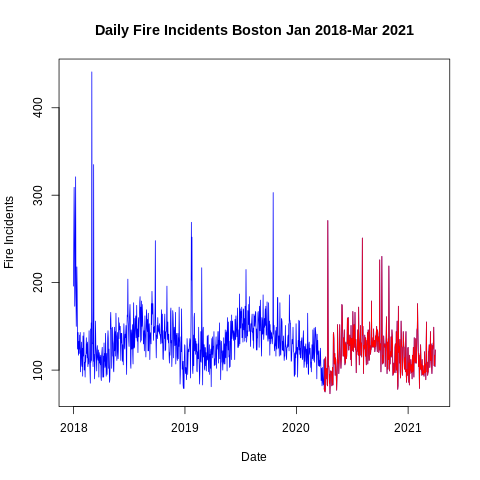

In [ ]:
%%R
plot(fire.summarized$Date,fire.summarized$incidents, type='l'
                              ,main='Daily Fire Incidents Boston Jan 2018-Mar 2021'
                              ,xlab='Date'
                              ,ylab='Fire Incidents'
                              ,col='blue')
lines(fire.test.data$Date,fire.test.data$incidents,col='red')

In [ ]:
%%R 
incident.desc <- table(fire.dat$Incident.Description[fire.dat$Date <'2018-02-01'])
incident.desc[order(incident.desc ,decreasing=T)[1:10]]



Water or steam leak                                
                                               762 
Public service                                     
                                               469 
Central station, malicious false alarm             
                                               392 
Cooking fire, confined to container                
                                               344 
Good intent call, Other                            
                                               293 
Smoke detector activation, no fire - unintentional 
                                               232 
Alarm system activation, no fire - unintentional   
                                               212 
Dispatched & cancelled en route                    
                                               209 
Alarm system sounded due to malfunction            
                                               177 
Direct tie to FD, malicious false alarm            
           

# Model Fitting

At this point we begin modeling in `stan`. Our initial focus was on poisson likelihoods given the unbounded count nature of the data. The hierarchical structure was decided because it is reasonable to assume the drivers of fire incident alarms may vary throughout the year, and this would lead to different incident frequencies. The time series plot in the ETL/EDA section was in line with this theory. To blindly hypothesize for illustrative purposes, in the winter maybe fire incidents occur as a result of heating a home, where in the summer possibly outdoor fires or grilling cause the incidents. We also admit in advance this model may be a fairly naive approach to modeling time series data as it does not account for autocorrelation in the daily counts, but the model choice was determined in part by the timeline of the project, and we did not feel we would have the time to adequately understand the models which incorporate this information in the Bayesian context before the timeline was up. We settled on a model of the following form as a starting point. 

$$\begin{align}
 y_{ij} &\sim  \text{Poisson}(\lambda_j) \\
 \lambda_j &\sim  \text{Gamma}(\alpha,\beta) \\
 \alpha &\sim \text{student-}t (11,0,20) \\
 \beta &\sim \text{student-}t (11,0,20) \\
\end{align}$$

The $j$ in formulae below refer to a given month where $j \in [1,12]$ with 1 corresponding to January through 12 corresponding to December. The student-$t$ hyperpriors were chosen after intially attempting normal hyperpriors in an attempt to increase the dispersion in the model, with the degrees of freedom chosen as $\nu = J-1 = 11$, 1 less than the number of monthly groups. This blog proved helpful in providing a working template for heirarchical poisson models in `stan`:  https://dm13450.github.io/2019/06/05/Conjugate-Stan.html.

In the end when plotting the posterior predictive distributions against the actual data observed in each month we saw that the poisson model drastically underestimated the uncertainty in the data. For that reason we swithed to a likelihood of the following form $$p(y_{ij}) = \binom{y_{ij}+\phi-1}{y_{ij}} \left(\frac{\mu_{j}}{\mu_{j} + \phi}\right)^{y_{ij}} \left(\frac{\phi}{\mu_{j} + \phi}\right)^{\phi}$$ Which for any given $y_{ij}$ has expectation $\mu_{j}$ and variance $\mu_j + \frac{\mu_j^2}{\phi}$ [https://mc-stan.org/docs/2_18/functions-reference/nbalt.html]. As we can see this allows for more uncertainty in $y_{ij}$ realtive to the poisson model where both mean and variance are simply the rate parameter $\lambda_j$. The full model is now as follows: 

$$\begin{align}
 y_{ij} &\sim  \text{Negative Binomial}(\mu_j,\phi) \\
 \mu_j &\sim  \text{Gamma}(\alpha,\beta) \\
 \alpha &\sim \text{student-}t (11,0,20) \\
 \beta &\sim \text{student-}t (11,0,20) \\
 \ln \phi &\sim \text{Uniform} (-\infty, \infty) \\
\end{align}$$


In [ ]:
#Negative Binomial likelihood model string
#section  13.2 stan manual https://mc-stan.org/docs/2_20/functions-reference/nbalt.html
%%R
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
NegBinHierString = " 
data {
  int<lower=0> N;
  int<lower=0> NGroups;
  int y[N];
  int group[N];
}

parameters {
  real<lower=0> mu[NGroups];
  real<lower=0> alpha0;
  real<lower=0> beta0;
  real logphi;
}

model {
  alpha0 ~ student_t(11,0, 20);
  beta0 ~ student_t(11,0, 20);
  mu ~ gamma(alpha0, beta0);
  
  for(i in 1:N)
    y[i] ~ neg_binomial_2(mu[group[i]], exp(logphi) );
}


"

In [ ]:
%%R
NegBinDSO = stan_model(model_code=NegBinHierString)

In [ ]:
%%R
NegBinFit = sampling(object=NegBinDSO,
                   data=list(N=n,NGroups =J, y=y.ji,group=month),
                   chains=3, warmup=500, iter=4000, seed=202004132)

# Model Summary

In [ ]:
%%R
options(width = 200)
summary(NegBinFit)$summary

               mean      se_mean          sd         2.5%          25%          50%          75%        97.5%     n_eff      Rhat
mu[1]  1.397775e+02 0.0233552090  2.70652768 1.346022e+02 1.379517e+02 1.397476e+02 1.415499e+02 1.450511e+02 13429.425 0.9998594
mu[2]  1.201438e+02 0.0196105320  2.47322355 1.154083e+02 1.184566e+02 1.201209e+02 1.217707e+02 1.250536e+02 15905.525 0.9997395
mu[3]  1.222232e+02 0.0194900737  2.39509387 1.176329e+02 1.206029e+02 1.221752e+02 1.238016e+02 1.270908e+02 15101.431 0.9997751
mu[4]  1.172619e+02 0.0237616492  2.79440877 1.118539e+02 1.153398e+02 1.172342e+02 1.191622e+02 1.227635e+02 13830.144 0.9998666
mu[5]  1.289480e+02 0.0262377917  3.04764063 1.231520e+02 1.268492e+02 1.288990e+02 1.309893e+02 1.349979e+02 13491.895 0.9999770
mu[6]  1.403892e+02 0.0260221350  3.39191259 1.339637e+02 1.380878e+02 1.403120e+02 1.426740e+02 1.471112e+02 16990.394 0.9998993
mu[7]  1.483545e+02 0.0293360575  3.44952113 1.416721e+02 1.460371e+02 1.482954e+02 1.5061

##MCMC Diagnostics

Throughout this section the following link proved helpful in providing some background on the diagnostics and software used: https://cran.r-project.org/web/packages/bayesplot/vignettes/visual-mcmc-diagnostics.html


### Trace Plot
From the trace plots ($\ln \phi$ example printed below) we can see that each chain covers most of the sample space and shows no visible trend or pattern. This suggests we neither face a problem of sampling from an incorrect distribution or from lack of samples.


In [ ]:
%%R
posterior_cp = as.array(NegBinFit)

No divergences to plot.


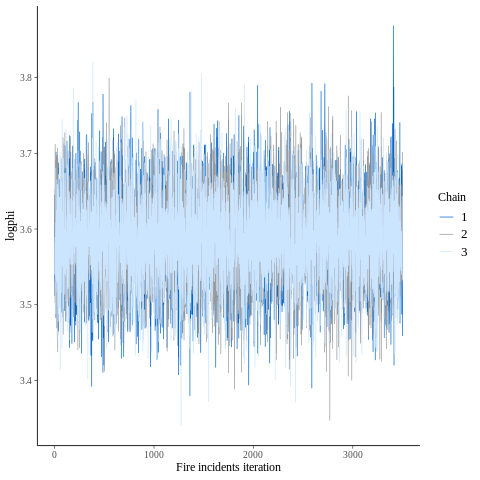

In [ ]:
%%R
color_scheme_set("mix-brightblue-gray")
mcmc_trace(posterior_cp, pars = "logphi", np = nuts_params((NegBinFit))) + 
  xlab("Fire incidents iteration")

### Rhat
Looking at the rhats plot, we can see that all the rhat values are pretty close to 1. This suggests that all the chains are in equillibrium
This in turn means that the chains have converged to a common distribution. We can easily show the opposite of this by reducing the number of iterations in fit_cp_bad_rhat to 50 to find rhat values greater than 1.



In [ ]:
%%R

fit_cp_bad_rhat <- NegBinFit
#changing iter to 50 shows how a poor sample would look like in terms of rhat
rhats = rhat(fit_cp_bad_rhat)
print(rhats)

    mu[1]     mu[2]     mu[3]     mu[4]     mu[5]     mu[6]     mu[7]     mu[8]     mu[9]    mu[10]    mu[11]    mu[12]    alpha0     beta0    logphi      lp__ 
0.9998594 0.9997395 0.9997751 0.9998666 0.9999770 0.9998993 1.0000903 1.0001447 0.9998661 0.9998959 0.9999989 0.9999297 0.9997423 0.9997497 1.0002793 1.0000060 


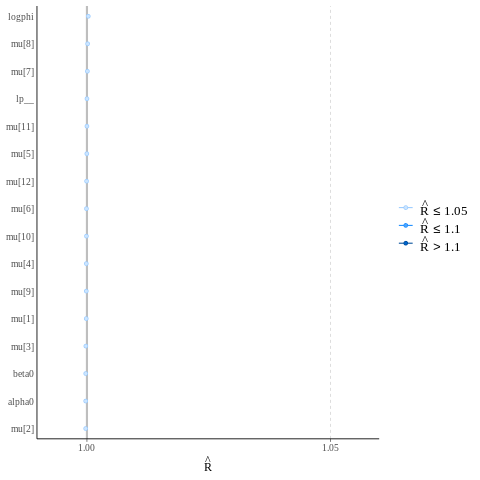

In [ ]:
%%R
color_scheme_set("brightblue") # see help("color_scheme_set")
mcmc_rhat(rhats) + yaxis_text(hjust = 1)

###Effective Sample size
Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, neff, is usually smaller than the total sample size, N (although it may be larger in some cases). The larger the ratio of neff to N the better

Since we have pretty high ratios all greater than or near 0.5, we don't need to worry about the effective sample size.


    mu[1]     mu[2]     mu[3]     mu[4]     mu[5]     mu[6]     mu[7]     mu[8]     mu[9]    mu[10]    mu[11]    mu[12]    alpha0     beta0    logphi      lp__ 
1.2789929 1.5148119 1.4382316 1.3171566 1.2849424 1.6181328 1.3168152 1.3099582 1.2695871 1.1981380 1.3569716 1.2966075 0.6308173 0.6366140 1.1575991 0.4575275 


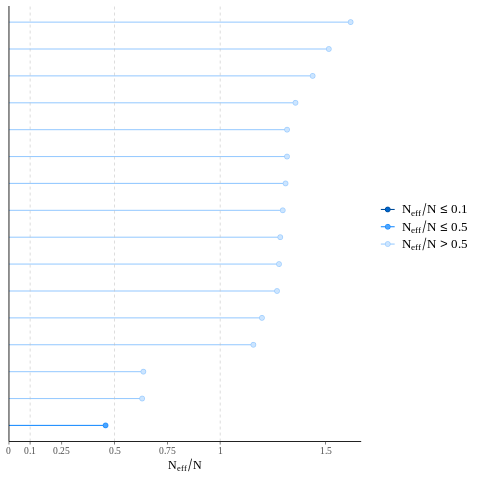

In [ ]:
%%R
ratios_cp <- neff_ratio(NegBinFit)
print(ratios_cp)

mcmc_neff(ratios_cp, size = 2)

###ACF
For the selected parameters, these functions show the autocorrelation for each Markov chain separately up to a user-specified number of lags.
Positive autocorrelation is bad (it means the chain tends to stay in the same area between iterations) and you want it to drop quickly to zero with increasing lag.
Negative autocorrelation is possible and it is useful as it indicates fast convergence of sample mean towards true mean.

We can see that for each chain, the acf function drops to 0 as lag increases for our hyperparameters.
Whereas the acf function for our parameters drops even more quickly, even showing negative autocorrelation.

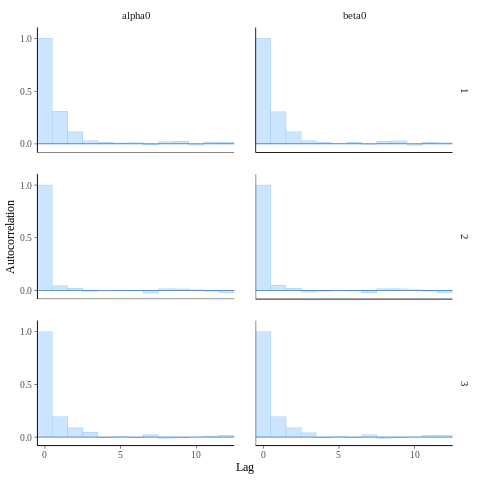

In [ ]:
%%R
mcmc_acf_bar(posterior_cp, pars = c("mu[1]","mu[2]","mu[3]","mu[4]","mu[5]","mu[6]","mu[7]","mu[8]","mu[9]","mu[10]","mu[11]","mu[12]","logphi"), lags = 12)
mcmc_acf_bar(posterior_cp, pars = c("alpha0","beta0"), lags = 12)

# Posterior Analysis
## Monthly Variable Intercepts
Looking at our posterior summaries we see that the distrutions of the monthly incident rates are approximately gaussian with shifting means and HDI. The distribution with the lowest estimated average incident rate is April (`mu[4]` in the graphic below) and the highest is September (`mu[9]` in the graphic below). It is  positive to see that the model does seem to capture a similar seasonal pattern to the actual time series plotted in the ETL/EDA section

## Dispersion Parameter
The natural log of the dispersion parameter is nicely gaussian with a median of 3.58 (85% PI = [3.5, 3.675]).

In [ ]:
%%R
NegBin.samples <- as.data.frame(NegBinFit)

R[write to console]: ci_level: 0.85 (85% intervals)

R[write to console]: outer_level: 0.95 (95% intervals)



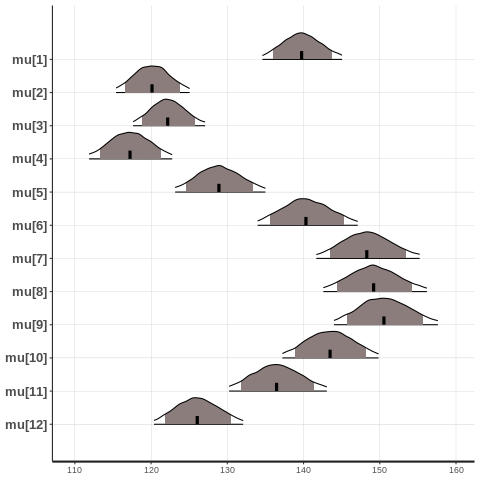

In [ ]:
%%R
#Plot posteriors
plot(NegBinFit, show_density = TRUE, ci_level = 0.85, fill_color = "mistyrose4", pars = paste0("mu[", 1:12, "]"))


R[write to console]: ci_level: 0.85 (85% intervals)

R[write to console]: outer_level: 0.95 (95% intervals)



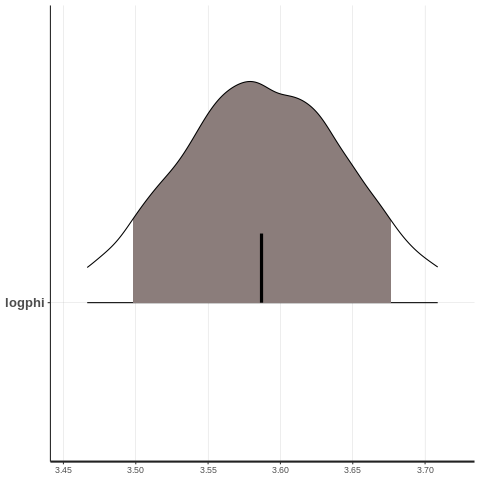

In [ ]:
%%R
# Dispersion
plot(NegBinFit, show_density = TRUE, ci_level = 0.85, fill_color = "mistyrose4", pars = c('logphi'))

## Hyperparameters
The distributions of the hyperparameters of our Gamma prior exhibit a slightly skewed shape with a median of 55 (85% PI = [32,91]) for $\alpha$ and similarly for $\beta$ which has posterior distribution centering on 0.4 (85% PI = [0.225, 0.65]). 

R[write to console]: ci_level: 0.85 (85% intervals)

R[write to console]: outer_level: 0.95 (95% intervals)



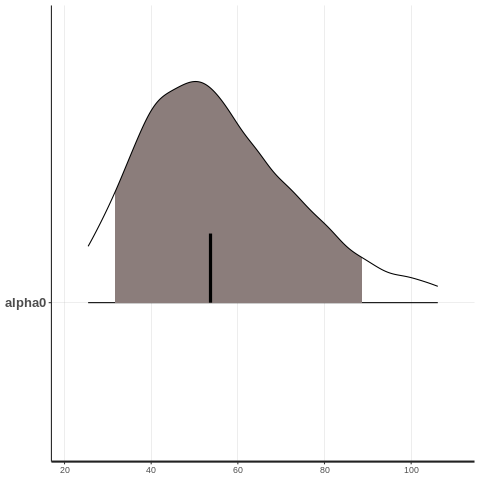

In [ ]:
%%R
# Alpha hyperparameter
plot(NegBinFit, show_density = TRUE, ci_level = 0.85, fill_color = "mistyrose4", pars = c('alpha0'))

R[write to console]: ci_level: 0.85 (85% intervals)

R[write to console]: outer_level: 0.95 (95% intervals)



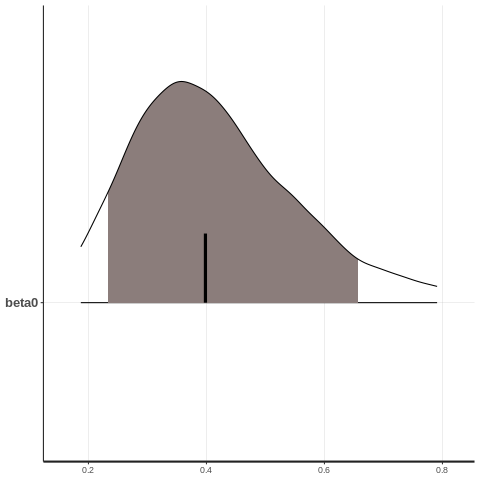

In [ ]:
%%R
# Beta hyperparameter
plot(NegBinFit, show_density = TRUE, ci_level = 0.85, fill_color = "mistyrose4", pars = c('beta0'))

# Posterior Prediction

## Comparisons to Training Set Monthly Distributions

We next compare the densitites of the monthly posterior predictive distributions to the actual distribitions of incidence numbers in the raw data in 2020. We see in this check the model generally seems to fit the distribution of the training data reasonably well for the most part. January seems to have the most questionable fit with the model's samples shifted seemlingly too far to the right in the body of the distribution and without a long enough right tail. This is not too surprising given the stretch of unusually large observations in January 2018 at the start of the series are likely causing the model to over-forecast this month in general. 

In [ ]:
%%R
NegBin.samples <- as.data.frame(NegBinFit)
y_sample <- matrix(data = NA, nrow = nrow(NegBin.samples), ncol = 12, byrow = FALSE,
       dimnames = NULL)

In [ ]:
%%R
 # y1 <- rep(NA,nrow(stan.samples))
for (j in 1:12){
    for (i in 1:nrow(NegBin.samples)){
     # y_sample[i,j]<- rpois(1,stan.samples[i,j])
     y_sample[i,j]<- rnbinom(1,mu=NegBin.samples[i,j],size=exp(NegBin.samples[i,c('logphi')]))
  }
}

y_sample[1:5,1:5]

     [,1] [,2] [,3] [,4] [,5]
[1,]  157  150  133   93  137
[2,]  105  120   84  102  138
[3,]  101   66  112   97  140
[4,]  204  128  105   88  133
[5,]  171  119  106  111  113


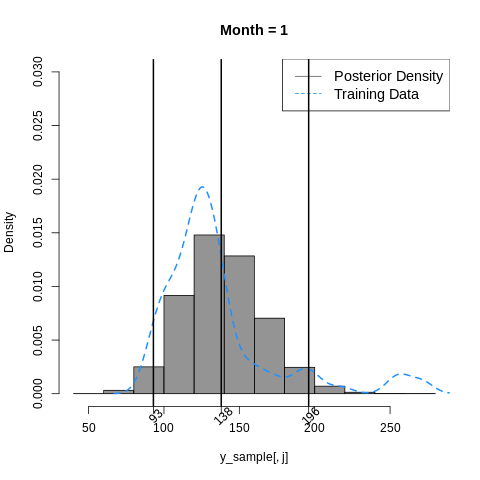

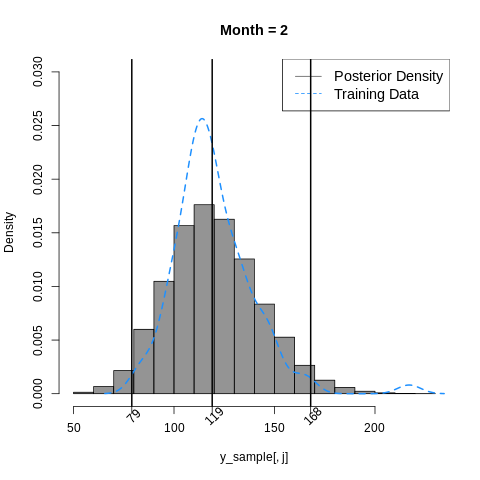

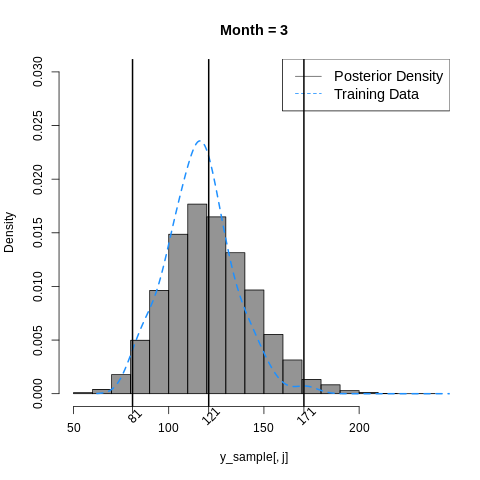

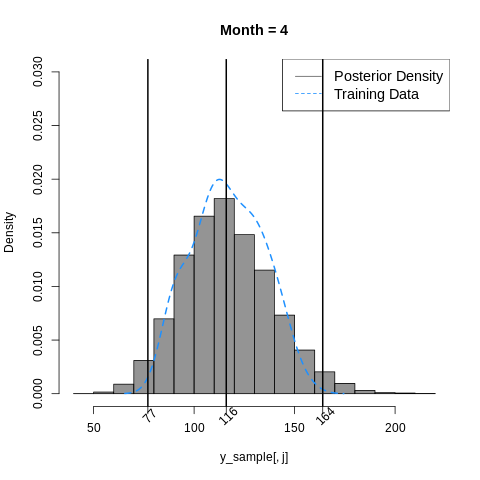

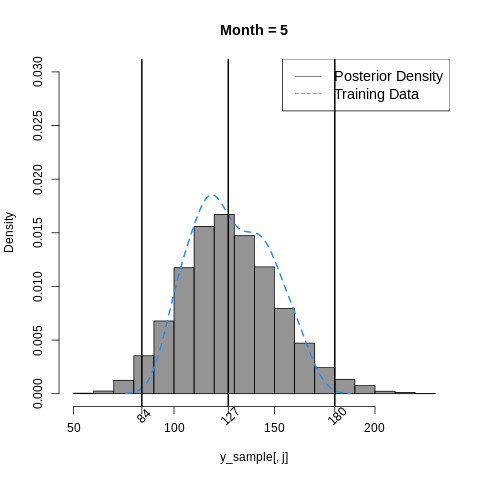

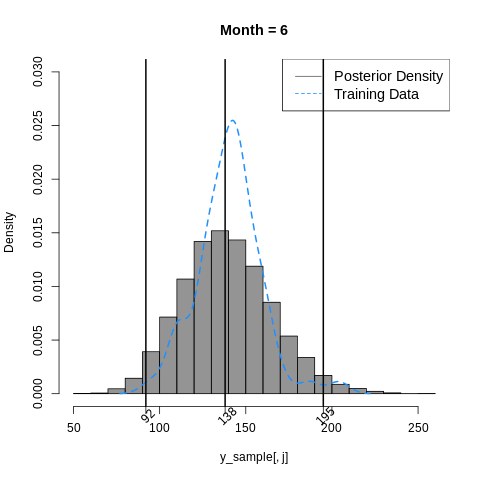

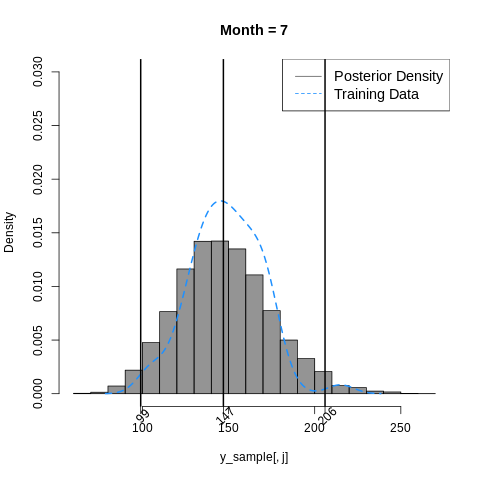

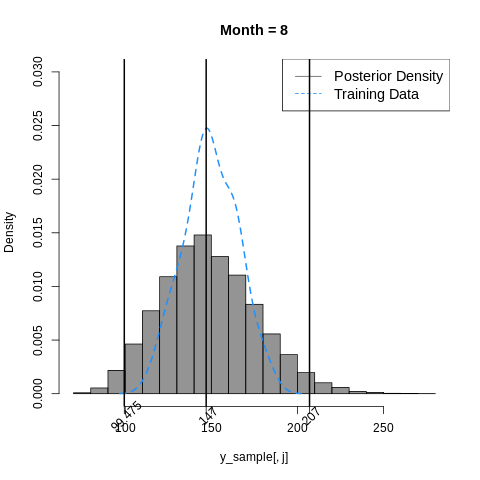

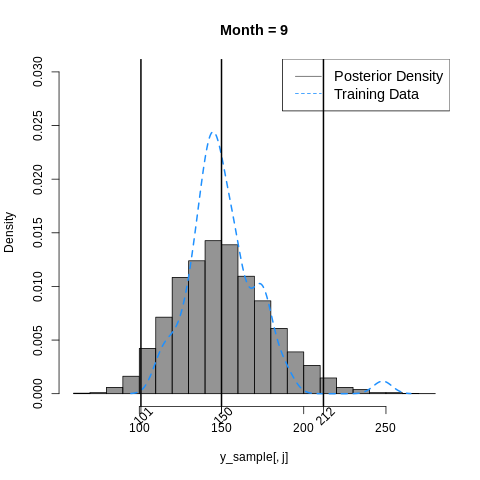

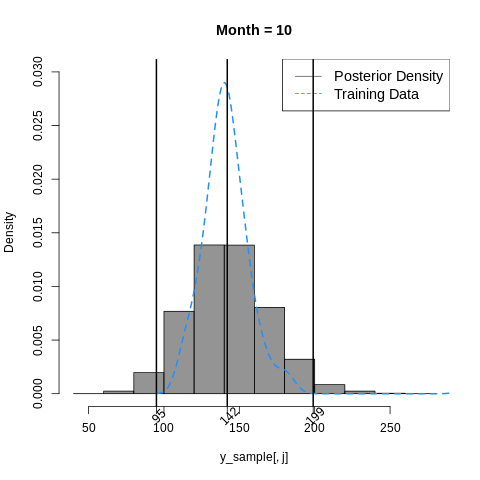

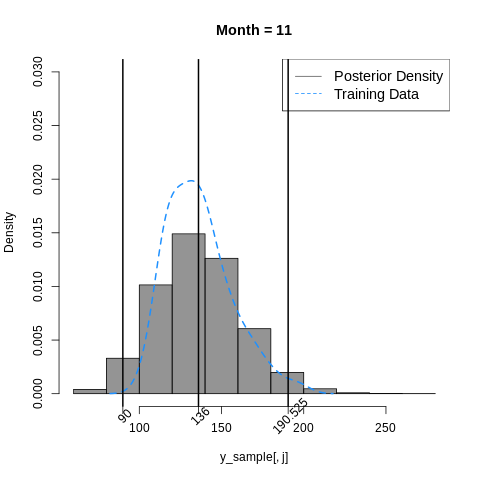

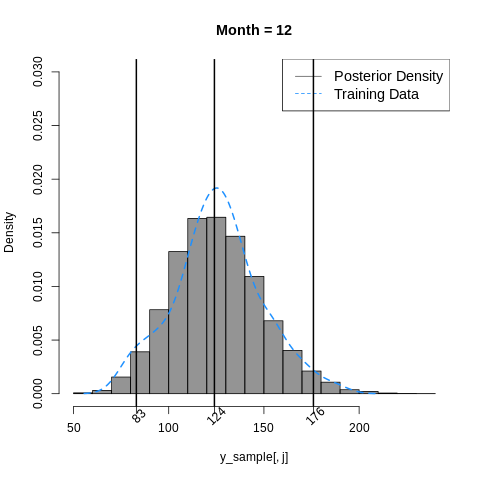

In [ ]:
%%R
# Posterior plots with raw data
for (j in 1:12){
  hist(y_sample[,j],main=paste0('Month = ',j),col=rgb(0.3,0.3,0.3, alpha = 0.6), freq = FALSE, ylim = c(0,0.03))
  lines(density(fire.training.data$incidents[fire.training.data$month==j]), col = "dodgerblue", lwd = 2, lty = 2)
  legend("topright",c("Posterior Density","Training Data"),cex=1.2,col=c(rgb(0.3,0.3,0.3), "dodgerblue"), lty=c(1,2))
  abline(v=quantile(y_sample[,j],probs=c(.025,.5,.975)),lwd=c(2,2,2))
  axis(side=1, at=quantile(y_sample[,j],probs=c(.025)), labels = FALSE)
  text(x=quantile(y_sample[,j],probs=c(.025)),  par("usr")[3]
       , labels =   quantile(y_sample[,j],probs=c(.025)), srt = 45, pos = 1, xpd = TRUE)

    axis(side=1, at=quantile(y_sample[,j],probs=c(.5)), labels = FALSE)
  text(x=quantile(y_sample[,j],probs=c(.5)),  par("usr")[3]
       , labels =   quantile(y_sample[,j],probs=c(.5)), srt = 45, pos = 1, xpd = TRUE)

    axis(side=1, at=quantile(y_sample[,j],probs=c(.975)), labels = FALSE)
  text(x=quantile(y_sample[,j],probs=c(.975)),  par("usr")[3]
       , labels =   quantile(y_sample[,j],probs=c(.975)), srt = 45, pos = 1, xpd = TRUE)
}


## Comparisons to Test Set Monthly Distributions

With our posterior estimates we now compare the estimated densitites to those of the 12 months in the test set. From the below it appears that on average the model is overestimating the daily counts. This is likely due to the outbreak of COVID, which in Boston began to seriously alter normal life in March 2020, which is the last month in the training set. The fact that March 2021 was among the test months best predicted by the model is additional evidence that the overwise general over-forecasting trend is largely due to COVID altering the behavior of Bostonians.



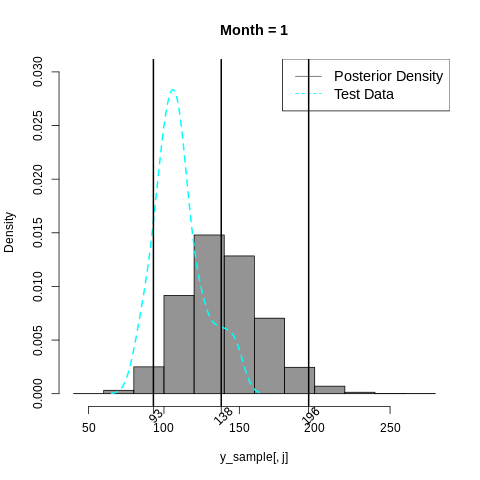

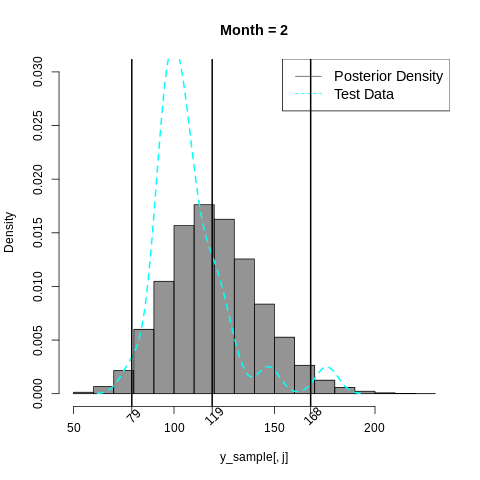

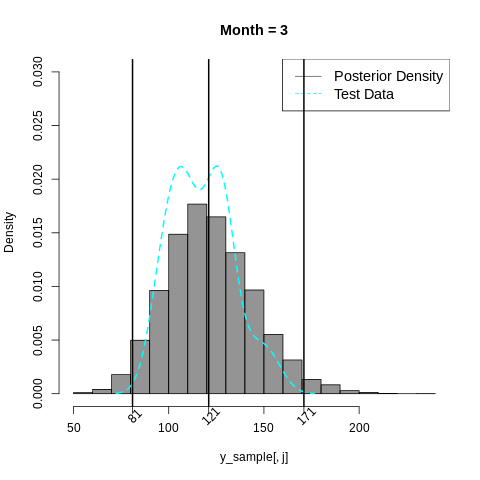

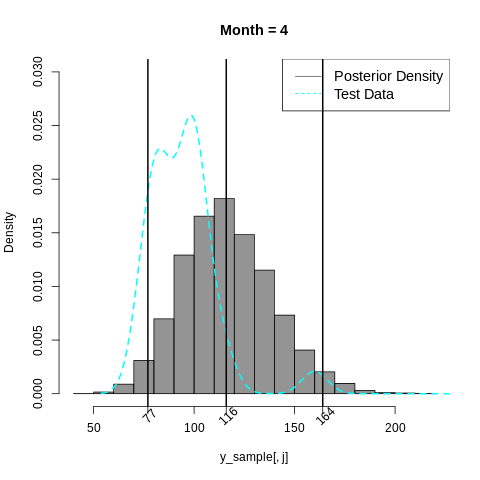

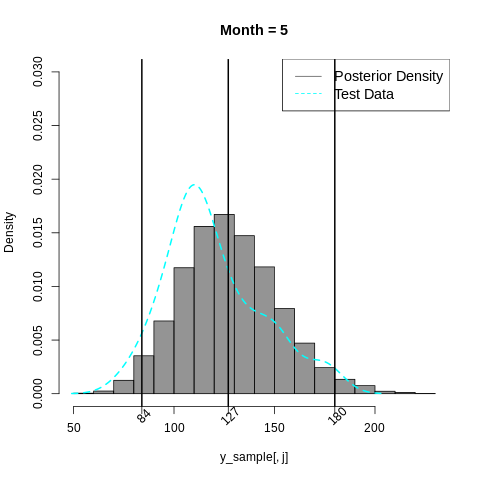

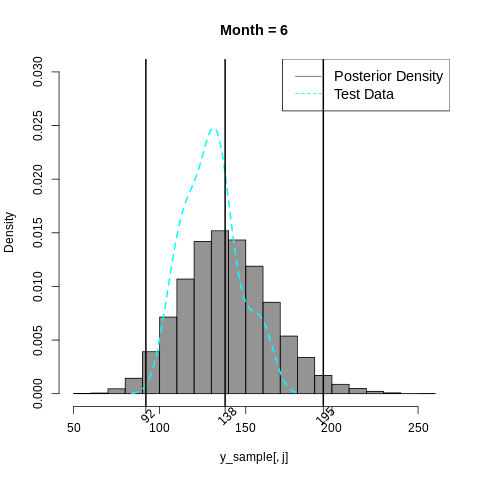

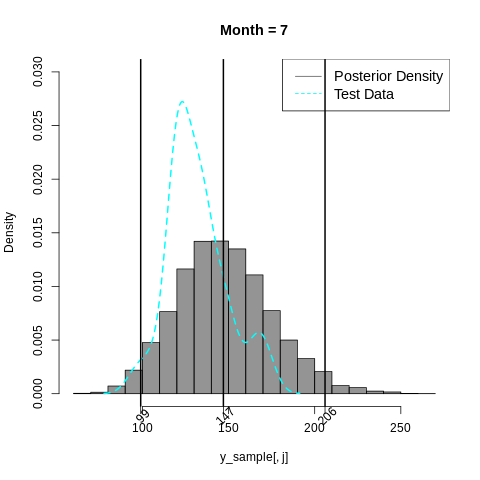

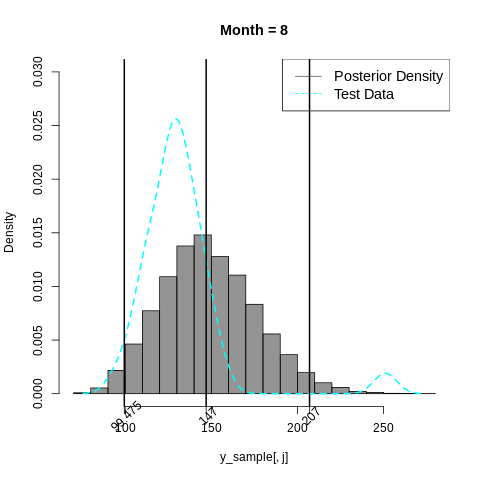

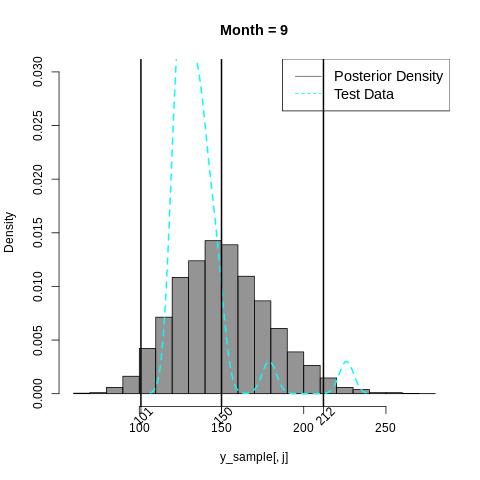

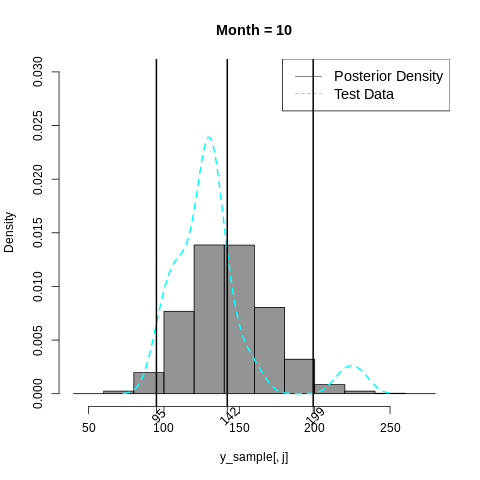

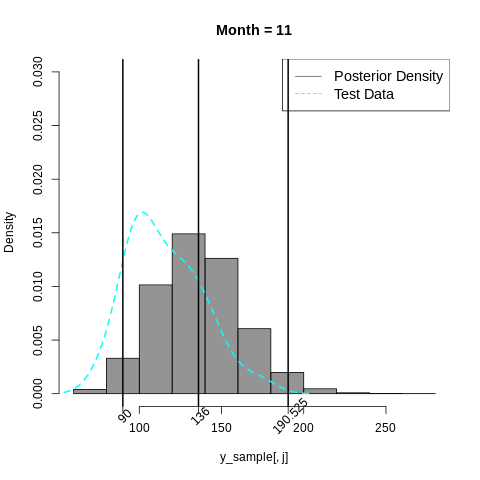

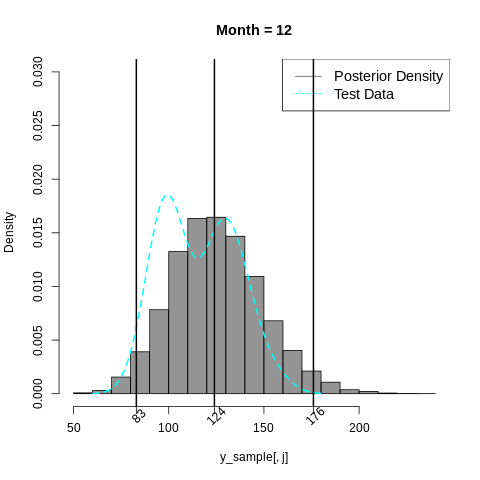

In [ ]:
%%R
# Posteriors with the raw data from the test data set
for (j in 1:12){
  hist(y_sample[,j],main=paste0('Month = ',j),col=rgb(0.3,0.3,0.3, alpha = 0.6), freq = FALSE, ylim = c(0,0.03))
  lines(density(fire.test.data$incidents[fire.test.data$month==j]), col = "cyan", lwd = 2, lty = 2)
  legend("topright",c("Posterior Density","Test Data"),cex=1.2,col=c(rgb(0.3,0.3,0.3), "cyan"), lty=c(1,2))
  abline(v=quantile(y_sample[,j],probs=c(.025,.5,.975)),lwd=c(2,2,2))
  axis(side=1, at=quantile(y_sample[,j],probs=c(.025)), labels = FALSE)
  text(x=quantile(y_sample[,j],probs=c(.025)),  par("usr")[3]
       , labels =   quantile(y_sample[,j],probs=c(.025)), srt = 45, pos = 1, xpd = TRUE)

    axis(side=1, at=quantile(y_sample[,j],probs=c(.5)), labels = FALSE)
  text(x=quantile(y_sample[,j],probs=c(.5)),  par("usr")[3]
       , labels =   quantile(y_sample[,j],probs=c(.5)), srt = 45, pos = 1, xpd = TRUE)

    axis(side=1, at=quantile(y_sample[,j],probs=c(.975)), labels = FALSE)
  text(x=quantile(y_sample[,j],probs=c(.975)),  par("usr")[3]
       , labels =   quantile(y_sample[,j],probs=c(.975)), srt = 45, pos = 1, xpd = TRUE)
}


## Posterior Predictive Tests

As a further check to test the model's forecasting on the test data for the final year we designed the test in this section. In the context of the problem we felt a test statistic which calculated the maximum observed incidents in a sample size matching the appropriate number of days for a given month would be appropriate. The reasoning being it probably be a greater concern if a city anticipated too few fire incidents than too many as in the former case the concern is simply added expense where in latter the implication may be the city is unequiped to handle the actual volume of fire incidents. Meaning we are most concerned with the calibration of the upper tail of the distribution. 

The test in this case is to use each of the posterior samples drawn from the model to simulate a month of fire incident counts, $\tilde{y}_{ij}^{I} \quad \text{for }  i = 1,2,..,\text{final day month } j$ . Then for each batch calculate $T_{j,max}^{(I)} = \text{max}(\tilde{y}_{ij}^{I})$. This statistic can then be calculated for each of the actual months in the test set, $T_{j,\text{max}}$, and used to calculate a two sided $p$-value to assess whether the actual results are in line with the model's prediction.

The results are printed below, with the histograms showing the test statistics derived from the samples, and the vertical lines showing the actual results. Several results fall fairly safely in the expected range given by the posterior distribution; May 2020, Sep 2020, Oct 2020, Nov 2020, Feb 2021 and Mar 2021. 6 of the overall 12. Jun 2020, July 2020, Aug 2020, and Dec 2020 all have $p$-values in the range of .04-.10. For these 4 months their actual $T_{\max}$ is unlikely but still very much possible in the posterior distributions from the model. But the fact that 4 of 12 fall in this range with another 2 month's actual test statistics even less likely implies this model could use refinement in order to more accurately estimate the upper tail of the population distribution. 

Focusing more specifically on the 2 highly unexpected results. It seems in January the problem is one of overestimation in the distribution of Fire Incidents. This likely has much to do with the extreme month in 2018 driven by a 'once in a hundred years' event. This may be a good example of a siutation where a model which takes  autocorrelation in account is superior to the simple monthly hierarchical model, as it could take into account the fact that recent results were not nearly as extreme. In April we see the opposite issue, a very high outlier in the month that was based on the model and training data has the lowest daily rate of fires. 




In [ ]:
%%R
set.seed(425)


y_test <- matrix(data = NA, nrow = nrow(NegBin.samples), ncol = 12, byrow = FALSE,
       dimnames = NULL)

#Number of samples to draw for each month 
days<-as.numeric((fire.test.data %>% group_by(month) %>% summarize(days=n()))$days)

 # y1 <- rep(NA,nrow(stan.samples))
for (j in 1:12){
    for (i in 1:nrow(NegBin.samples)){
     # y_sample[i,j]<- rpois(1,stan.samples[i,j])
     y_test[i,j]<- max(rnbinom(days[j],mu=NegBin.samples[i,j],size=exp(NegBin.samples[i,c('logphi')])))
  }
}
y_test[1:5,1:3]

     [,1] [,2] [,3]
[1,]  208  168  175
[2,]  193  157  169
[3,]  205  174  170
[4,]  206  179  170
[5,]  184  189  167


In [ ]:
%%R
#Get actuals T_max
fire.test.max <- fire.test.data %>% group_by(year,month) %>% summarize(Tmax = max(incidents))
fire.test.max

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.
# A tibble: 12 x 3
# Groups:   year [2]
    year month  Tmax
   <dbl> <dbl> <int>
 1  2020     4   271
 2  2020     5   175
 3  2020     6   160
 4  2020     7   172
 5  2020     8   251
 6  2020     9   226
 7  2020    10   230
 8  2020    11   173
 9  2020    12   156
10  2021     1   148
11  2021     2   176
12  2021     3   155



 Test Month =  4 

 2 sided p-value =  0 

 Test Month =  5 

 2 sided p-value =  0.6337143 

 Test Month =  6 

 2 sided p-value =  0.004380952 

 Test Month =  7 

 2 sided p-value =  0.00647619 

 Test Month =  8 

 2 sided p-value =  0.05504762 

 Test Month =  9 

 2 sided p-value =  0.4401905 

 Test Month =  10 

 2 sided p-value =  0.155619 

 Test Month =  11 

 2 sided p-value =  0.1874286 

 Test Month =  12 

 2 sided p-value =  0.08514286 

 Test Month =  1 

 2 sided p-value =  0 

 Test Month =  2 

 2 sided p-value =  0.6428571 

 Test Month =  3 

 2 sided p-value =  0.1521905 


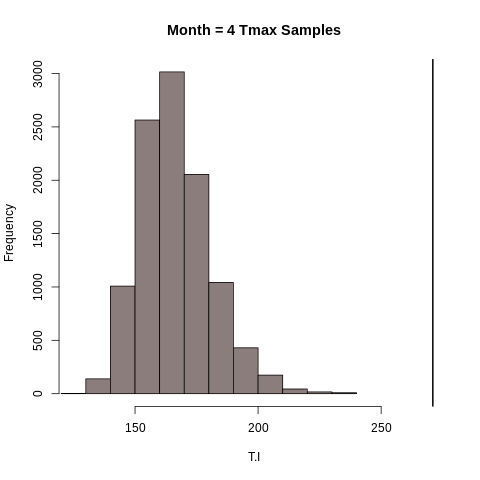

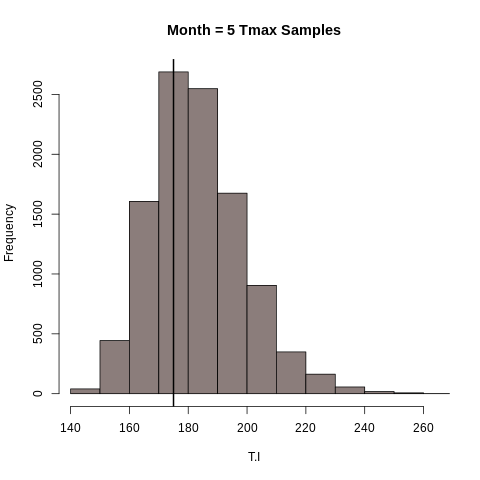

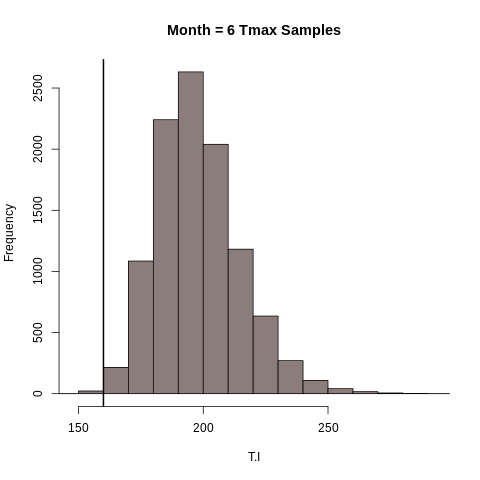

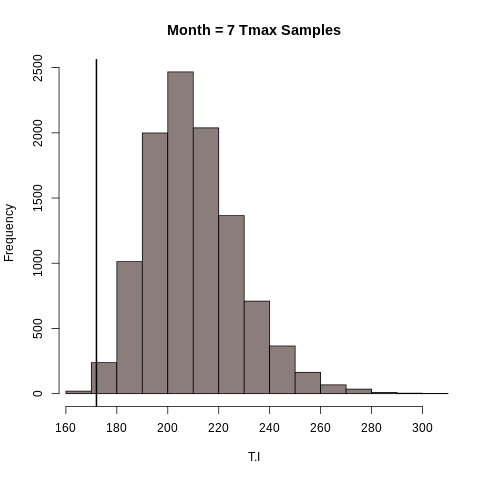

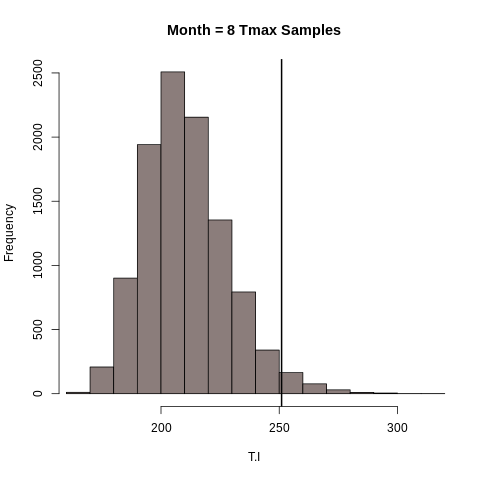

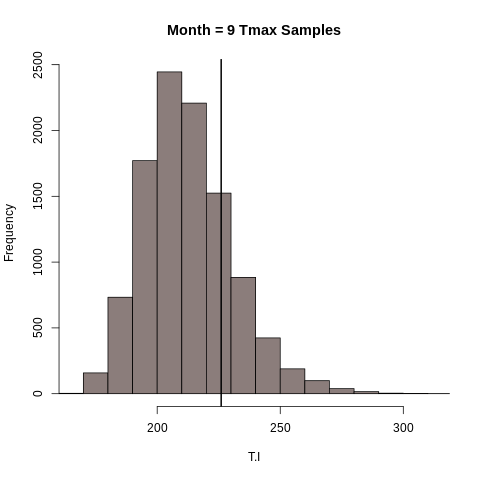

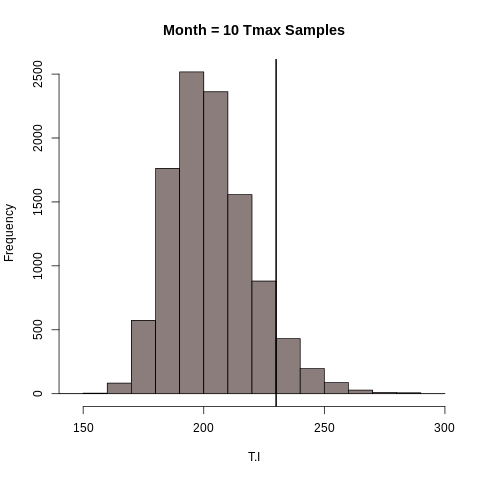

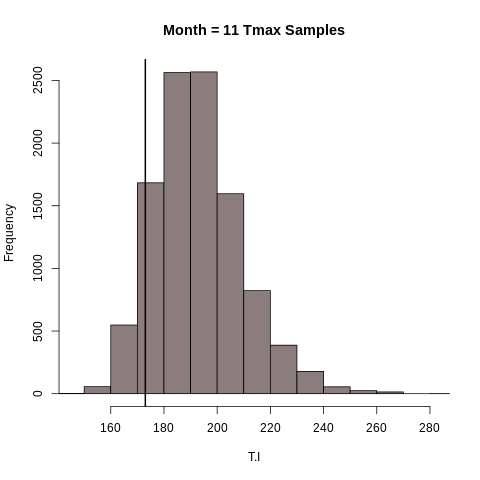

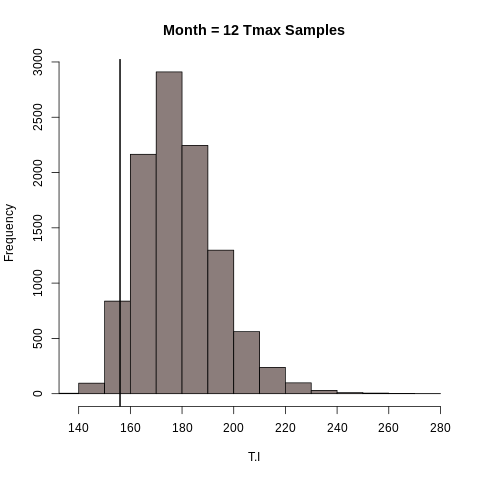

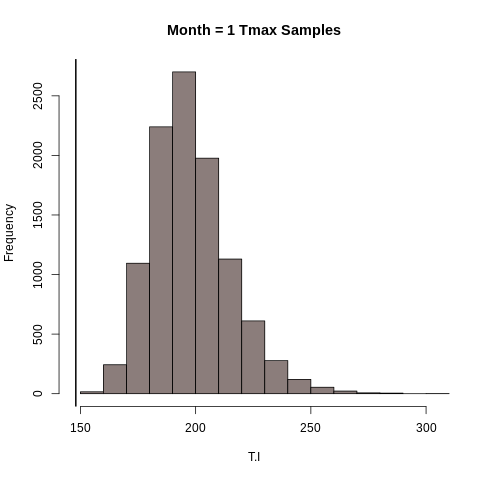

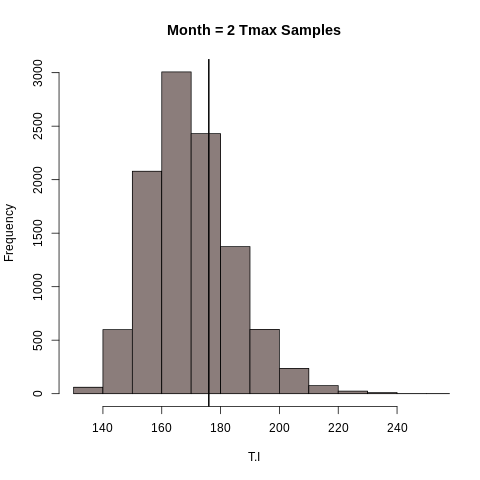

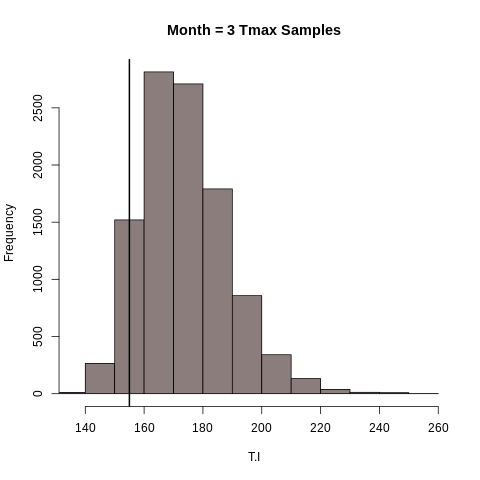

In [ ]:
%%R

#Run Posterior predictive tests using Max test statistic 
for (j in 1:12){
    active.month <- as.integer(fire.test.max[j,c('month')])
    cat('\n Test Month = ',active.month, '\n')
    
    T<- as.numeric(fire.test.max[j,3])
    T.I <- y_test[,active.month ]
    cat('\n 2 sided p-value = ',2*min(mean(T.I>=T),mean(T.I<=T)), '\n')

    xmin<-min(c(T.I,T))
    xmax<-max(c(T.I,T))
    hist(T.I,col='mistyrose4',main=paste0('Month = ',active.month , ' Tmax Samples'), xlim=c(xmin-1,xmax+1))
    abline(v=T,lwd=2)

}


# Conclusion

In this report we explored the use of a simple Bayesian hierarchical model with a Negative Binomial likelihood as a forecasting approach for daily fire incidents within a given month. There were no issues in fitting of this model in `stan` as shown in the MCMC diagnostics. We saw that for the most part the model was able to capture the high level seasonal trend observed in the data, and that the monthly posterior predictive distributions matched those of the training data well, though when compared to the data in the test set we saw some overforecasting was occuring likely due to COVID. 

In general as anticipated we see the limitations of this model form when applied to this weather related time series problem. The calibration of the upper tail probabilites proved to be a challenge, as is often the case with data which is at least partially dependent on the weather. Additionally the inability to take into account autocorrelation in this model means recent trends are not considered when forecasting new months. Futhermore, if a more granular forecast was needed, for example the posterior predictive distribution at the daily level, this model will also miss the within month variation in those distributions. Which we see is likely to be important given the smooth increasing and decreasing trends in the actual time series plots of the historic data. If we were to expand on this project a reasonable next step would be to change the model form to one which is designed to incorporate more aspects of time series structure.

# Appendix:

## Poisson Uncertainty

This analysis was initially proposed as a problem which could be modeled with a Poisson likelihood (with the full form specified in the Model Fitting section), here we fit that model and replot some of the results from above showing that the uncertainty in the rate parameters with the Poisson approach is a poorer fit to this data.

In [ ]:
#Poisson likelihood model string
%%R
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
PoisHierString = " 
data {
  int<lower=0> N;
  int<lower=0> NGroups;
  int y[N];
  int group[N];
}

parameters {
  real<lower=0> lambda[NGroups];
  real<lower=0> alpha0;
  real<lower=0> beta0;

}

model {
  alpha0 ~ student_t(11,0, 20);
  beta0 ~ student_t(11,0, 20);
  
  lambda ~ gamma(alpha0, beta0);
  
  for(i in 1:N)
    y[i] ~ poisson(lambda[group[i]]);
}


"

PoisDSO = stan_model(model_code=PoisHierString)
PoisFit = sampling(object=PoisDSO,
                   data=list(N=n,NGroups =J, y=y.ji,group=month),
                   chains=3, warmup=500, iter=4000, seed=202004132)

In [ ]:
%%R
set.seed(425)

Pois.samples <- as.data.frame(PoisFit)

y_test <- matrix(data = NA, nrow = nrow(Pois.samples), ncol = 12, byrow = FALSE,
       dimnames = NULL)

for (j in 1:12){
    for (i in 1:nrow(Pois.samples)){
     y_test[i,j]<- max(rpois(days[j],Pois.samples[i,j]))
    # y_test[i,j]<- max(rnbinom(days[j],mu=Pois.samples[i,j],size=exp(Pois.samples[i,c('logphi')])))
  }
}

Here we attempt the same posterior predictive test on the maximum sampled daily incident count as we did previously in the Posterior Predictive Tests section. We now see 5 of 12 months with $p$-value effectively of 0, where the actual $T_{\max}$ for the month fell well to the right of the posterior predictive distribution proposed by the model. There are two additional months with $p$-values less than .05, and 1 additional month with a value less than $.1$. The remaining 4 month's actual statistic seemed to fall reasonably in the body of the expected distributions. We remember that the Negative Binomial model did struggle somewhat in these tests as well, but the upper tail proposed by that model certainly appears to be better calibrated than the Poisson approach based on these results.


 Test Month =  4 

 2 sided p-value =  0 

 Test Month =  5 

 2 sided p-value =  0.003428571 

 Test Month =  6 

 2 sided p-value =  0.4647619 

 Test Month =  7 

 2 sided p-value =  0.8405714 

 Test Month =  8 

 2 sided p-value =  0 

 Test Month =  9 

 2 sided p-value =  0 

 Test Month =  10 

 2 sided p-value =  0 

 Test Month =  11 

 2 sided p-value =  0.08590476 

 Test Month =  12 

 2 sided p-value =  0.3060952 

 Test Month =  1 

 2 sided p-value =  0.001142857 

 Test Month =  2 

 2 sided p-value =  0 

 Test Month =  3 

 2 sided p-value =  0.144381 


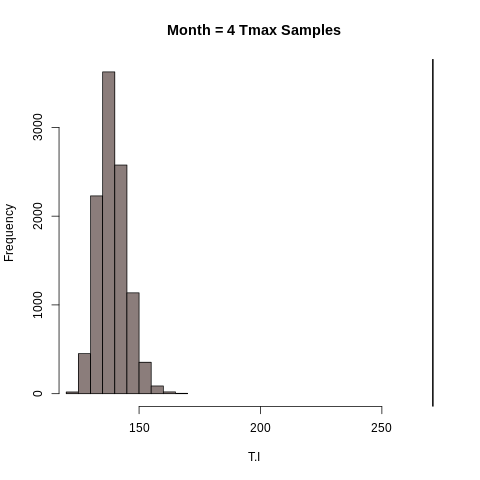

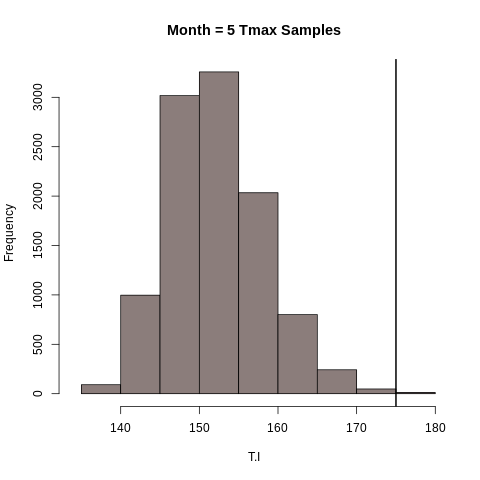

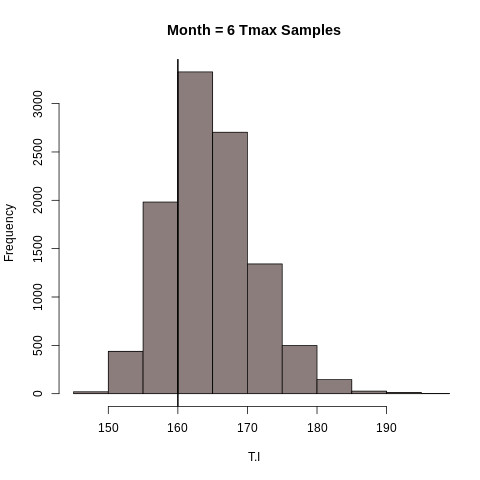

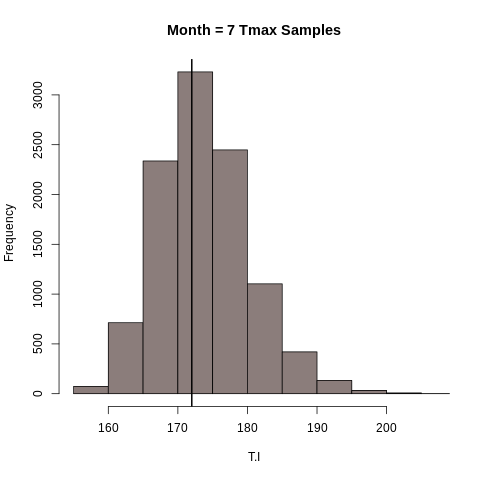

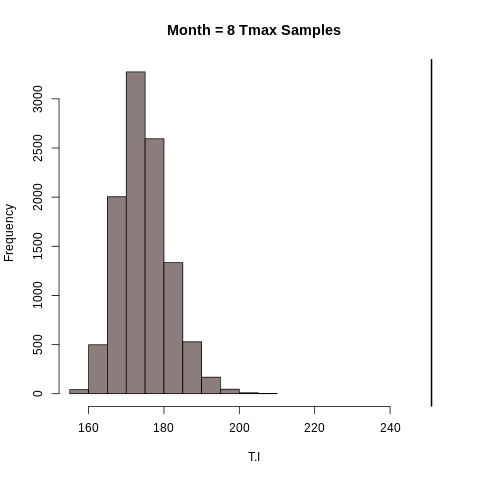

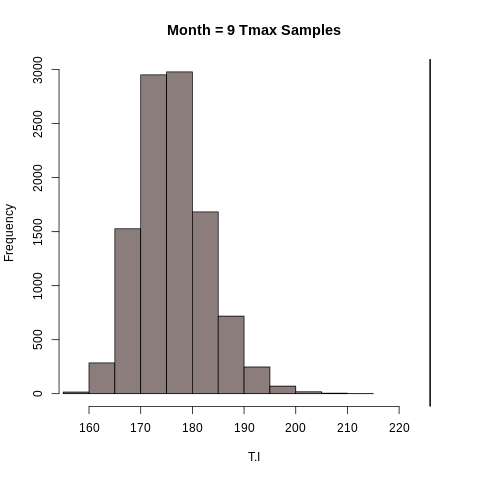

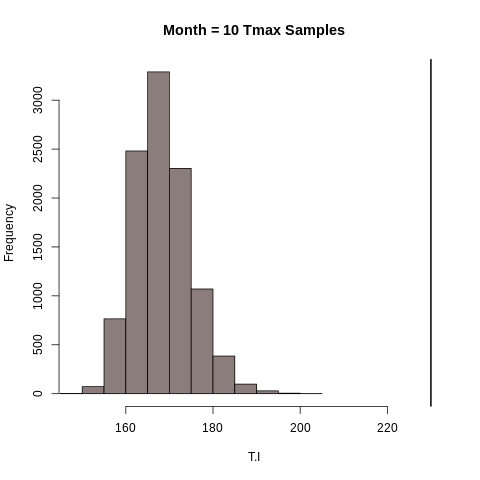

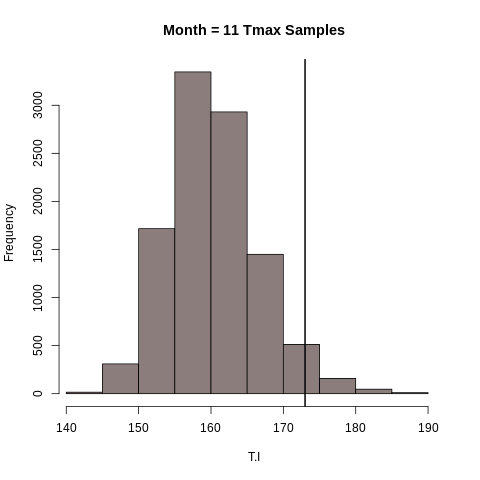

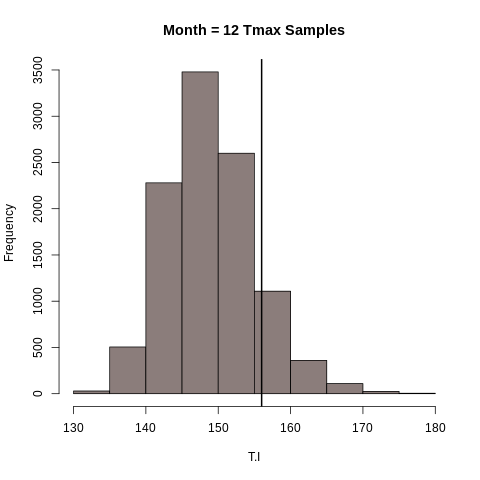

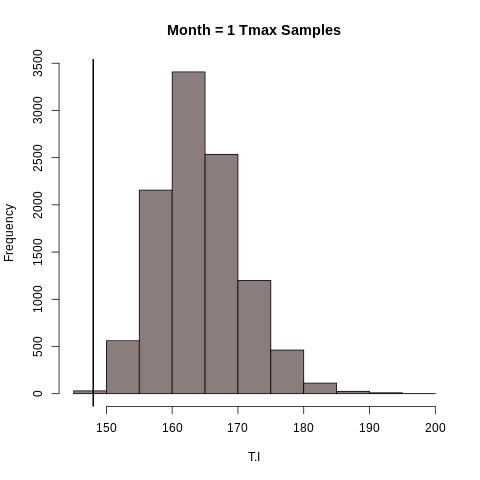

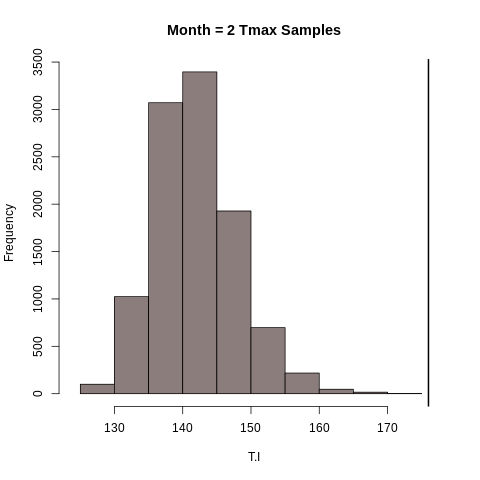

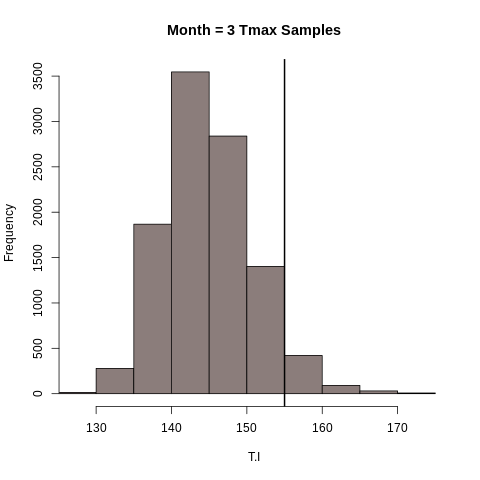

In [ ]:
%%R
#Run Posterior predictive tests using Max test statistic 
for (j in 1:12){
    active.month <- as.integer(fire.test.max[j,c('month')])
    cat('\n Test Month = ',active.month, '\n')
    
    T<- as.numeric(fire.test.max[j,3])
    T.I <- y_test[,active.month ]
    cat('\n 2 sided p-value = ',2*min(mean(T.I>=T),mean(T.I<=T)), '\n')

    xmin<-min(c(T.I,T))
    xmax<-max(c(T.I,T))
    hist(T.I,col='mistyrose4',main=paste0('Month = ',active.month , ' Tmax Samples'), xlim=c(xmin-1,xmax+1))
    abline(v=T,lwd=2)

}
